<div style="display: flex; flex-direction: column; align-items: center; font-family: 'Arial';">
    <h1 style="color: #2c3e50;">
        <strong>Predicción de la Cantidad de Alumnos que Ingresan por un Pasillo de la UNI</strong>
    </h1>
    <hr style="width: 100%; border: 1px solid #3498db;">    
    <h2 style="color: #16a085;">
        Práctica Calificada de Computación Gráfica - Universidad Nacional de Ingeniería
    </h2>    
    <div style="display: flex; width: 100%; justify-content: space-between; padding: 10px;">
        <div style="flex: 1; padding-right: 20px;">
            <h3 style="font-family: 'Courier New'; color: #8e44ad;">Integrantes:</h3>
            <ul style="list-style-type: circle;">
                <li><strong>Estudiante 1:</strong> <a href="" target="_blank" style="text-decoration: none; color: #2980b9;">Barrientos Cardenas, Gabriel Adrians</a></li>
                <li><strong>Estudiante 2:</strong> <a href="" target="_blank" style="text-decoration: none; color: #2980b9;">Del Rosario Sosa, Joshua Jean Paul</a></li>
                <li><strong>Estudiante 3:</strong> <a href="" target="_blank" style="text-decoration: none; color: #2980b9;">Yarleque Ramos, Gabriel Gerardo</a></li>
            </ul>
        </div>
        <div style="flex: 1; padding-left: 20px;">
            <h3 style="font-family: 'Courier New'; color: #16a085;">Curso:</h3>
            <h4 style="color: #2ecc71;">Computación Gráfica</h4>
        </div>
    </div>
    <hr style="width: 100%; border: 1px solid #8e44ad;">
    <div style="display: flex; flex-direction: column; align-items: center; text-align: justify; padding: 10px;">
        <h3 style="font-family: 'Courier New'; color: #16a085;">Descripción del Proyecto:</h3>
        <p style="color: #34495e;">
            En este cuaderno se desarrolla un modelo predictivo para estimar la cantidad de alumnos que ingresan por un pasillo en la Universidad Nacional de Ingeniería. Se utilizan técnicas de Machine Learning y visión computacional para analizar los datos recolectados a partir de sensores y cámaras, optimizando así el flujo de estudiantes en áreas de alto tráfico.
        </p>
    </div>



## Importación de Librerías

En este paso se importan las bibliotecas necesarias para realizar el procesamiento de video, manipulación de datos y análisis de imágenes.

In [284]:
import cv2
import pickle
import numpy as np
import os
import matplotlib.pyplot as plt
import skimage
from skimage.exposure import histogram, equalize_hist, equalize_adapthist

### Carga de datos
Cargamos el archivo espacios.pkl, el cual contiene las posiciones predeterminadas donde se esperan detectar personas.

In [285]:
detector_persona = []
with open('espacios.pkl', 'rb') as file:
    detector_persona = pickle.load(file)


### Lectura de videos
Leemos los videos de los tres periodos: mañana, tarde y noche. Además, obtenemos las dimensiones del primer video, que servirán como referencia para redimensionar los otros videos.

In [287]:
# Leer los 3 videos (mañana, tarde y noche)
# El metodo cv2.VideoCapture() permite leer un video
video1 = cv2.VideoCapture('video_1_temprano.mp4')
video2 = cv2.VideoCapture('video_2_tarde.mp4')
video3 = cv2.VideoCapture('video_3_noche.mp4')

# Obtener la resolución del primer video
# Se obtiene el primer frame del video
# Un frame es una imagen que forma parte de un video

ret1, frame1 = video1.read()
ret2, frame2 = video2.read()
ret3, frame3 = video3.read()

# Obtener las dimensiones del primer video
# Se obtiene la altura, ancho y canales de color del video
# La altura es el número de filas de la imagen
# El ancho es el número de columnas de la imagen
# Los canales de color son el número de colores que se utilizan para representar la imagen
# En este caso se utilizan 3 canales de color (RGB)
height1, width1, _ = frame1.shape
height2, width2, _ = frame2.shape
height3, width3, _ = frame3.shape

# Imprimir la resolucion del primer video
print('Resolución del video 1:', width1, 'x', height1)
print('Resolución del video 2:', width2, 'x', height2)
print('Resolución del video 3:', width3, 'x', height3)



Resolución del video 1: 1080 x 1920
Resolución del video 2: 1080 x 1920
Resolución del video 3: 720 x 1280


### Conversión a escala de grises

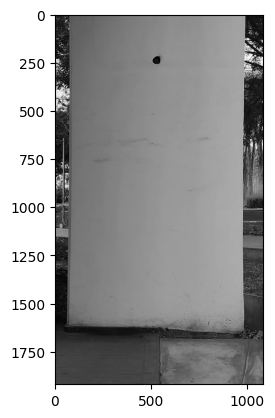

In [289]:
# Convertimos el primer fotograma a escala de grises para simplificar el análisis
img_gray = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)

# Como alternativa podemos convertir el fotograma a escala hsv
#img_hsv = cv2.cvtColor(frame1, cv2.COLOR_BGR2HSV)

# Mostramos el fotograma en escala de grises
plt.imshow(img_gray, cmap='gray')
plt.show()
# Mostramos el fotograma en escala hsv
#plt.imshow(img_hsv, cmap='hsv')

[[ 63  32  16 ...  12  14  44]
 [ 80  42  13 ...  22  23  47]
 [ 86  48  19 ...  21  20  34]
 ...
 [ 70  70  70 ... 100 100 100]
 [ 69  69  69 ... 101 101 101]
 [ 69  69  69 ...  97  97  97]]


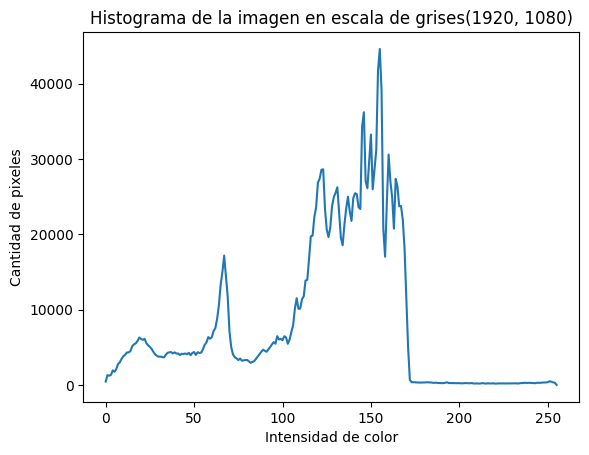

In [290]:
# Mostramos el arreglo de la imagen en escala de grises
print(img_gray)
img_gray = np.array(img_gray)
# Para ver la proporcion de pixeles, se puede utilizar el metodo hist()
plt.figure()
plt.title("Histograma de la imagen en escala de grises" + str(img_gray.shape))
plt.xlabel("Intensidad de color")
plt.ylabel("Cantidad de pixeles")
hist, bins = np.histogram(img_gray.flatten(), bins=256, range=[0,256])
plt.plot(bins[:-1], hist) 
plt.show()
# plt.plot(bins,hist)

### Aplicar umbral adaptativo

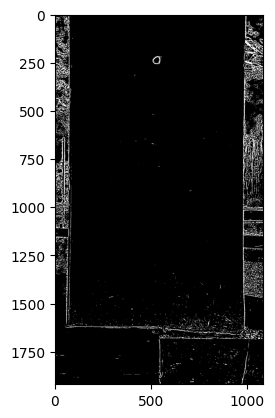

In [291]:
# Aplicamos el umbral adaptativo para destacar los objetos de interés
# El umbral adaptativo se calcula en base a la intensidad de los pixeles vecinos
# En este caso se utiliza el método de umbralización gaussiano
# El umbral se calcula en base a la media de los pixeles vecinos y una constante
# En este caso la constante es 16
# Parametros de la funcion cv2.adaptiveThreshold()
# 1. Imagen en escala de grises : img_gray
# 2. Valor maximo del pixel : 255
# 3. Metodo de umbralización : cv2.ADAPTIVE_THRESH_GAUSSIAN_C
# 4. Tipo de umbralización : cv2.THRESH_BINARY_INV  
# 5. Tamaño del vecindario : 25
# 6. Constante que se resta al promedio :



img_threshold = cv2.adaptiveThreshold(  img_gray, 
                                        255, 
                                        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                        cv2.THRESH_BINARY_INV, 
                                        25, 
                                        16)

# Mostramos la imagen umbralizada
plt.imshow(img_threshold, cmap='gray')
plt.show()

### Aplicar filtro de mediana

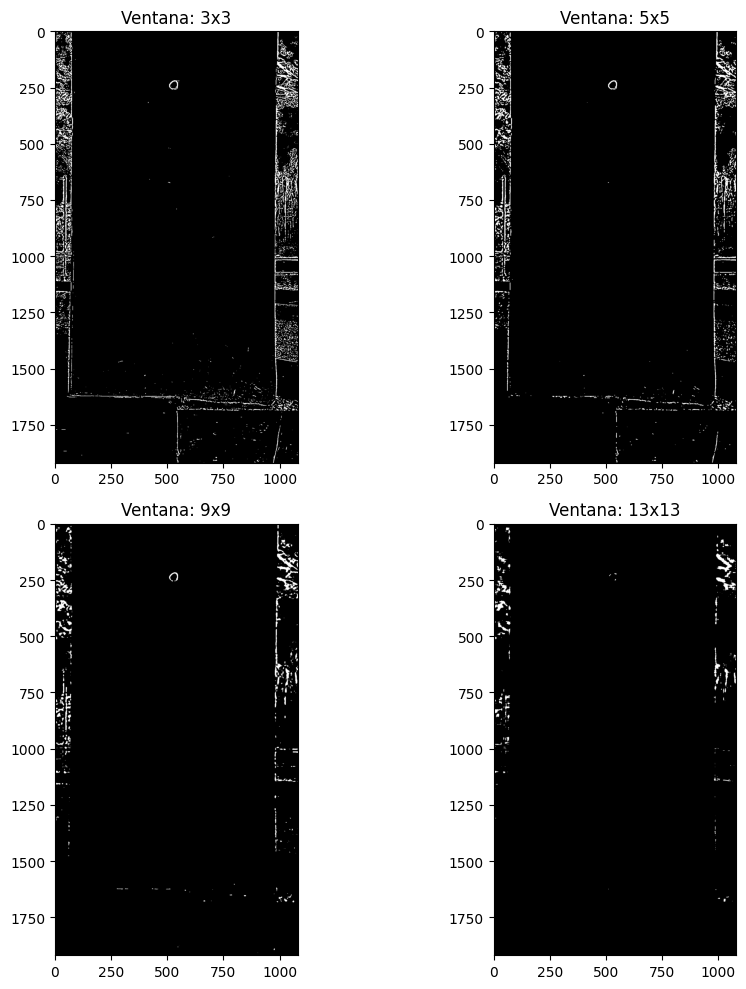

In [293]:
ventana_size = [3, 5, 9, 13]

# Aplicamos el filtro de mediana con diferentes tamaños de kernel
img_median_1 = cv2.medianBlur(img_threshold, ventana_size[0])
img_median = cv2.medianBlur(img_threshold, ventana_size[1]) # Valor que utilizaremos para este proyecto
img_median_9 = cv2.medianBlur(img_threshold, ventana_size[2])
img_median_13 = cv2.medianBlur(img_threshold, ventana_size[3])

# Ajustamos las imagenes en un cuadro 2x2
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Mostramos las imágenes en escala de grises con diferentes ventana_size
axs[0, 0].imshow(img_median_1, cmap='gray')
axs[0, 0].set_title(f'Ventana: {ventana_size[0]}x{ventana_size[0]}')

axs[0, 1].imshow(img_median, cmap='gray')
axs[0, 1].set_title(f'Ventana: {ventana_size[1]}x{ventana_size[1]}')

axs[1, 0].imshow(img_median_9, cmap='gray')
axs[1, 0].set_title(f'Ventana: {ventana_size[2]}x{ventana_size[2]}')

axs[1, 1].imshow(img_median_13, cmap='gray')
axs[1, 1].set_title(f'Ventana: {ventana_size[3]}x{ventana_size[3]}')

plt.tight_layout()
plt.show()

### Dilatar la imagen

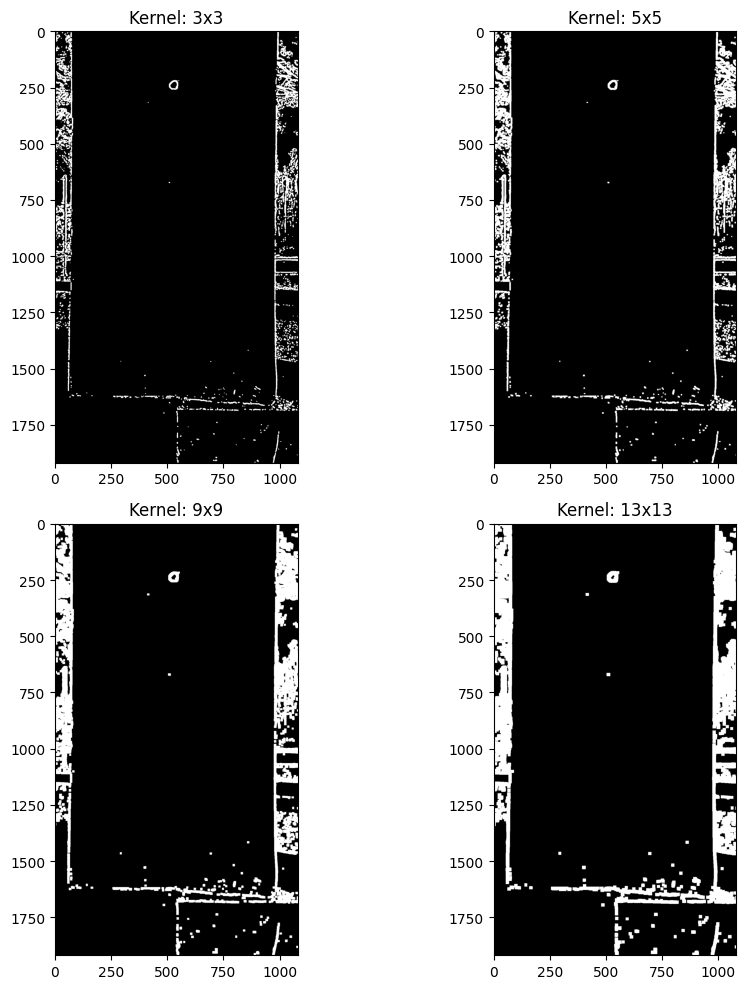

In [294]:
# Creamos un kernel para dilatar la imagen y expandir las áreas blancas
kernels = [ np.ones((3, 3), np.int8),
           np.ones((5, 5), np.int8),
           np.ones((9, 9), np.int8),
           np.ones((13, 13), np.int8)]
img_dilate_3 = cv2.dilate(img_median, kernels[0])
img_dilate = cv2.dilate(img_median, kernels[1])
img_dilate_9 = cv2.dilate(img_median, kernels[2])
img_dilate_13 = cv2.dilate(img_median, kernels[3])
# Ajustamos las imagenes en un cuadro 2x2
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].imshow(img_dilate_3, cmap='gray')
axs[0, 0].set_title(f'Kernel: 3x3')

axs[0, 1].imshow(img_dilate, cmap='gray')
axs[0, 1].set_title(f'Kernel: 5x5')

axs[1, 0].imshow(img_dilate_9, cmap='gray')
axs[1, 0].set_title(f'Kernel: 9x9')

axs[1, 1].imshow(img_dilate_13, cmap='gray')
axs[1, 1].set_title(f'Kernel: 13x13')
# Mostramos las imagenes dilatadas
plt.tight_layout()
plt.show()

# Procesamiento de Imágenes y Detección de Personas
Los pasos que utilizaremos son:
1. **Conversión a escala de grises**: Para simplificar el procesamiento al eliminar la información del color.
2. **Umbralización adaptativa**: Mostramos las áreas de interés, convirtiendo píxeles en blanco o negro mediante el uso del umbral.
3. **Aplicación de un filtro de mediana**: Elimina ruido en la imagen.
4. **Dilatación de la imagen**: Expande las áreas blancas, lo cual facilita la detección de objetos.

```python
def process_video(img, detector_persona, objeto_contador, ref_white_pixels, objeto_detectado, video_num):
    # Convertir a escala de grises
    imgBN = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Aplicar umbral adaptativo
    imgTH = cv2.adaptiveThreshold(imgBN, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 25, 16)
    # Aplicar filtro de mediana
    imgMedian = cv2.medianBlur(imgTH, 5)
    # Crear un kernel y aplicar dilatación
    kernel = np.ones((5, 5), np.int8)
    imgDil = cv2.dilate(imgMedian, kernel)

    # Detección de objetos
    for i, (x, y, w, h) in enumerate(detector_persona):
        x = x - 10
        y = y - 10
        w = w + 20
        h = h + 20
        espacio = imgDil[y:y+h, x:x+w]
        count = cv2.countNonZero(espacio)

        if i not in ref_white_pixels:
            ref_white_pixels[i] = count

        cv2.putText(img, f"Pixeles: {count}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 3)

        if count > ref_white_pixels[i] + 500:
            objeto_detectado = True
            cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 3)
            img_filename = f"detected_objects_video{video_num}/objeto_{objeto_contador + 1}.png"
            cv2.imwrite(img_filename, img)

        if objeto_detectado and count <= ref_white_pixels[i]:
            objeto_detectado = False
            objeto_contador += 1

    return img, objeto_contador, objeto_detectado


## Resultados de Detección de Personas

Los resultados del procesamiento de los videos fueron los siguientes:

- Cantidad de personas detectadas en la mañana: **14**
- Cantidad de personas detectadas en la tarde: **10**
- Cantidad de personas detectadas en la noche: **19**

A continuación, visualizaremos estos resultados y plantearemos un modelo predictivo para estimar la cantidad de personas en otros periodos de tiempo.


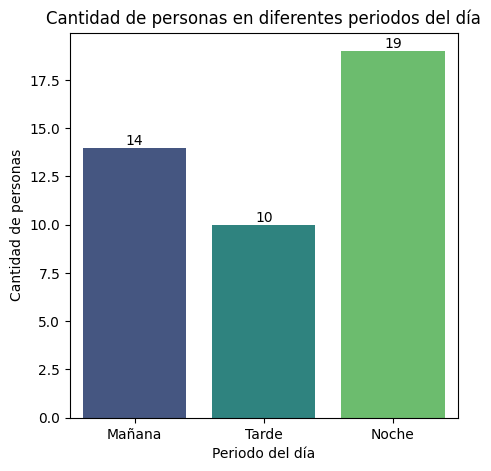

In [26]:
import seaborn as sns

# Datos de los resultados obtenidos
periodos = ['Mañana', 'Tarde', 'Noche']
cantidades = [14, 10, 19]

# Crear un gráfico de barras
plt.figure(figsize=(5, 5))
sns.barplot(x=periodos, y=cantidades , palette='viridis',hue=periodos)
plt.title('Cantidad de personas en diferentes periodos del día')
plt.ylabel('Cantidad de personas')
plt.xlabel('Periodo del día')

plt.text(0, cantidades[0], cantidades[0], ha='center', va='bottom')
plt.text(1, cantidades[1], cantidades[1], ha='center', va='bottom')
plt.text(2, cantidades[2], cantidades[2], ha='center', va='bottom')

plt.show()


Personas estimadas en 5 horas en la mañana: 840
Personas estimadas en 5 horas en la tarde: 600
Personas estimadas en 5 horas en la noche: 1140


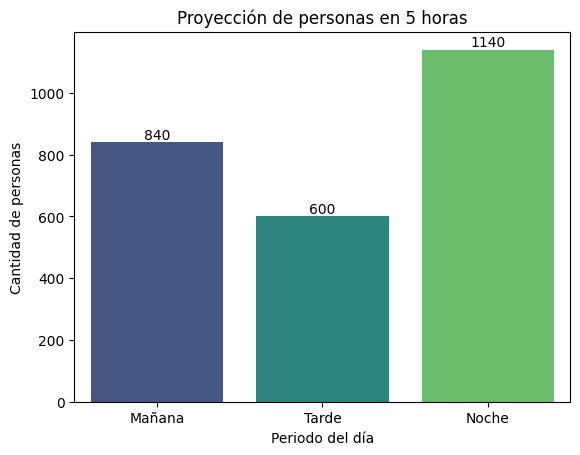

In [24]:
# Proyección de personas para 5 horas, considerando que se toman los resultados en 5 minutos

cant_mañana_5h = 14 * 12 * 5
cant_tarde_5h = 10 * 12 * 5
cant_noche_5h = 19 * 12 * 5

print(f"Personas estimadas en 5 horas en la mañana: {cant_mañana_5h}")
print(f"Personas estimadas en 5 horas en la tarde: {cant_tarde_5h}")
print(f"Personas estimadas en 5 horas en la noche: {cant_noche_5h}")

# Crear un gráfico de barras
sns.barplot(x=periodos, y=[cant_mañana_5h, cant_tarde_5h, cant_noche_5h], palette='viridis',hue=periodos)
plt.title('Proyección de personas en 5 horas')
plt.ylabel('Cantidad de personas')
plt.xlabel('Periodo del día')

# mostramos los valores
plt.text(0, cant_mañana_5h, cant_mañana_5h, ha='center', va='bottom')
plt.text(1, cant_tarde_5h, cant_tarde_5h, ha='center', va='bottom')
plt.text(2, cant_noche_5h, cant_noche_5h, ha='center', va='bottom')

plt.show()


In [45]:
error_prob = [ 0.7 , 0.2 , 0.1 ]
1 + np.random.choice( [0, 1, 2] , 1, p=error_prob)

array([1])

In [67]:
import numpy as np

# Considerar un error de ±10% para simular posibles errores de detección
error_factor = 2

# definir la matriz de error
error_prob = [ 0.7 , 0.2 , 0.1 ] # probabilidad de que haya 1 persona , 2 personas , 3 personas

# Proyección de personas para 5 horas, considerando que se toman los resultados en 5 minutos
cant_mañana_5h_error = 0
cant_tarde_5h_error = 0
cant_noche_5h_error = 0
for i in range(cant_mañana_5h):
    cant_mañana_5h_error += 1 + np.random.choice( [0, 1, 2] , 1, p=error_prob)
for i in range(cant_tarde_5h):
    cant_tarde_5h_error += 1 + np.random.choice( [0, 1, 2] , 1, p=error_prob)
for i in range(cant_noche_5h):
    cant_noche_5h_error += 1 + np.random.choice( [0, 1, 2] , 1, p=error_prob)

# Convertimos a entero
cant_mañana_5h_error = cant_mañana_5h_error[0]
cant_tarde_5h_error = cant_tarde_5h_error[0]
cant_noche_5h_error = cant_noche_5h_error[0]

print(f"Proyección con error en la mañana: {cant_mañana_5h_error}")
print(f"Proyección con error en la tarde: {cant_tarde_5h_error}")
print(f"Proyección con error en la noche: {cant_noche_5h_error}")


Proyección con error en la mañana: 1146
Proyección con error en la tarde: 821
Proyección con error en la noche: 1589


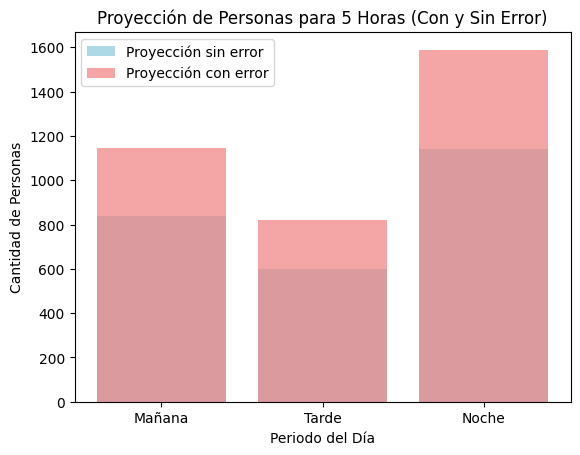

In [69]:
# Datos con proyección y con error
cantidades_5h = [cant_mañana_5h, cant_tarde_5h, cant_noche_5h]
cantidades_5h_error = [cant_mañana_5h_error, cant_tarde_5h_error, cant_noche_5h_error]

# Crear un gráfico comparativo
plt.bar(periodos, cantidades_5h, color='lightblue', label='Proyección sin error')
plt.bar(periodos, cantidades_5h_error, color='lightcoral', alpha=0.7, label='Proyección con error')
plt.title('Proyección de Personas para 5 Horas (Con y Sin Error)')
plt.xlabel('Periodo del Día')
plt.ylabel('Cantidad de Personas')
plt.legend()
plt.show()

### Contruimos un dataset de posibles predicciones

In [239]:
import numpy as np
import matplotlib.pyplot as plt

# Datos originales de personas detectadas en 5 minutos
cant_mañana_h = 14 * 12  # Proyección por hora para la mañana
cant_tarde_h = 10 * 12   # Proyección por hora para la tarde
cant_noche_h = 19 * 12   # Proyección por hora para la noche

# Diccionario de proyecciones por hora
proyecciones_h = { }

# Generar los valores de Y

error_prob = [0.9, 0.08, 0.02]  # probabilidad de que haya 1 persona, 2 personas, 3 personas

# creamos un Hue
hue = []

for i in range(1, 20):
    # Mañana de 5 a 12 [1,2,3,4,5,6,7]
    if i < 8:
        proyecciones_h[f'{i+4}-{i+4+1} am'] = cant_mañana_h + sum(  np.random.choice([0, 1, 2], 1, p=error_prob)[0] for _ in range(cant_mañana_h))
        hue.append('mañana')
    # Tarde de 12 a 6 [8,9,10,11,12,13]
    elif i < 14:
        proyecciones_h[f'{i+4}-{i+4+1} pm'] = cant_tarde_h + sum(  np.random.choice([0, 1, 2], 1, p=error_prob)[0] for _ in range(cant_tarde_h))
        hue.append('tarde')
    # Noche de 6 a 12 [14,15,16,17,18,19]
    else:
        proyecciones_h[f'{i+4}-{i+4+1} pm'] = cant_noche_h + sum(  np.random.choice([0, 1, 2], 1, p=error_prob)[0] for _ in range(cant_noche_h))
        hue.append('noche')
   


x = np.arange(len(proyecciones_h))  # Posiciones en el eje X

y = list(proyecciones_h.values())  # Valores en el eje Y   

In [240]:
# Imprimos el diccionario
for key, value in proyecciones_h.items():
    print(f"{key:10}: {value}")

5-6 am    : 186
6-7 am    : 190
7-8 am    : 181
8-9 am    : 182
9-10 am   : 187
10-11 am  : 184
11-12 am  : 186
12-13 pm  : 127
13-14 pm  : 139
14-15 pm  : 131
15-16 pm  : 131
16-17 pm  : 129
17-18 pm  : 134
18-19 pm  : 262
19-20 pm  : 257
20-21 pm  : 271
21-22 pm  : 250
22-23 pm  : 253
23-24 pm  : 255


### Visualización de los datos

<Figure size 1200x600 with 0 Axes>

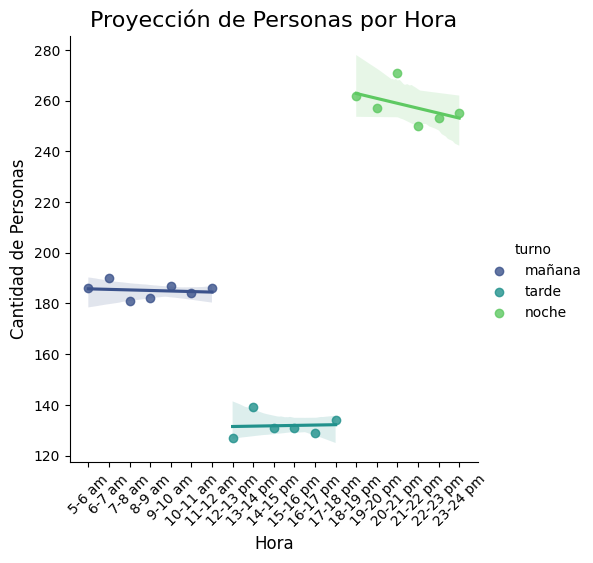

In [241]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Definir el tamaño de la figura para que el gráfico tenga el ancho adecuado
plt.figure(figsize=(12, 6))  # Ancho 12, alto 6 para una mejor visualización

# Crear el DataFrame con los datos
data = pd.DataFrame({
    'x': x,  # Valores del eje X (horas)
    'y': y,  # Valores del eje Y (cantidad de personas)
    'turno': hue  # Categoría para la variable 'turno'
})

# Graficar la regresión lineal utilizando sns.lmplot
sns.lmplot(x='x', y='y', data=data, hue='turno', palette='viridis')

# Configurar los ticks y la rotación de las etiquetas del eje X
plt.xticks(x, proyecciones_h.keys(), rotation=45)

# Añadir título y etiquetas
plt.title('Proyección de Personas por Hora', fontsize=16)
plt.xlabel('Hora', fontsize=12)
plt.ylabel('Cantidad de Personas', fontsize=12)

# Mostrar el gráfico
plt.show()



### Entrenamiento del Modelo

Para el turno mañana:
 - Pendiente (coeficiente): -0.21428571428571422
 - Intersección: 185.78571428571428
Para el turno tarde:
 - Pendiente (coeficiente): 0.14285714285714277
 - Intersección: 130.47619047619048
Para el turno noche:
 - Pendiente (coeficiente): -1.942857142857143
 - Intersección: 288.1142857142857


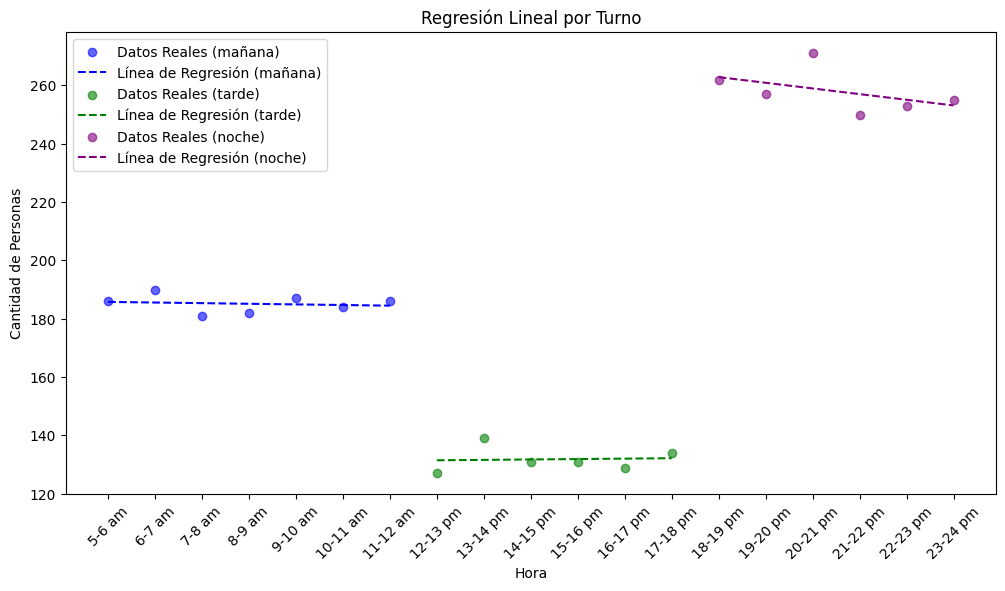

In [244]:
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Crear el DataFrame con los datos
data = pd.DataFrame({
    'x': x,  # Valores del eje X (horas)
    'y': y,  # Valores del eje Y (cantidad de personas)
    'turno': hue  # Categoría para la variable 'turno'
})

# Crear una figura
plt.figure(figsize=(12, 6))

# Colores diferentes para cada turno
colors = {'mañana': 'blue', 'tarde': 'green', 'noche': 'purple'}

modelos = []

# Hacer regresión lineal por cada 'turno'
for turno in data['turno'].unique():
    # Filtrar los datos por cada turno
    datos_turno = data[data['turno'] == turno]
    
    # Convertir los datos de x e y a formato numpy
    x_turno = np.array(datos_turno['x']).reshape(-1, 1)  # X necesita ser 2D para sklearn
    y_turno = np.array(datos_turno['y'])
    
    # Ajustar el modelo de regresión lineal
    modelo = LinearRegression()
    modelo.fit(x_turno, y_turno)

    # Guardar el modelo en la lista
    modelos.append(modelo)
    
    # Obtener los coeficientes
    pendiente = modelo.coef_[0]
    interseccion = modelo.intercept_
    
    print(f"Para el turno {turno}:")
    print(f" - Pendiente (coeficiente): {pendiente}")
    print(f" - Intersección: {interseccion}")
    
    # Graficar los puntos reales
    plt.scatter(x_turno, y_turno, color=colors[turno], label=f'Datos Reales ({turno})', alpha=0.6)
    
    # Graficar la línea de regresión
    plt.plot(x_turno, modelo.predict(x_turno), color=colors[turno], label=f'Línea de Regresión ({turno})', linestyle='--')


# Configurar los ticks y la rotación de las etiquetas del eje X
plt.xticks(x, proyecciones_h.keys(), rotation=45)

# Añadir etiquetas y título
plt.title('Regresión Lineal por Turno')
plt.xlabel('Hora')
plt.ylabel('Cantidad de Personas')
plt.legend()
plt.show()


### Prediccion 

Alumnos que pasarán a las 8 am: 184


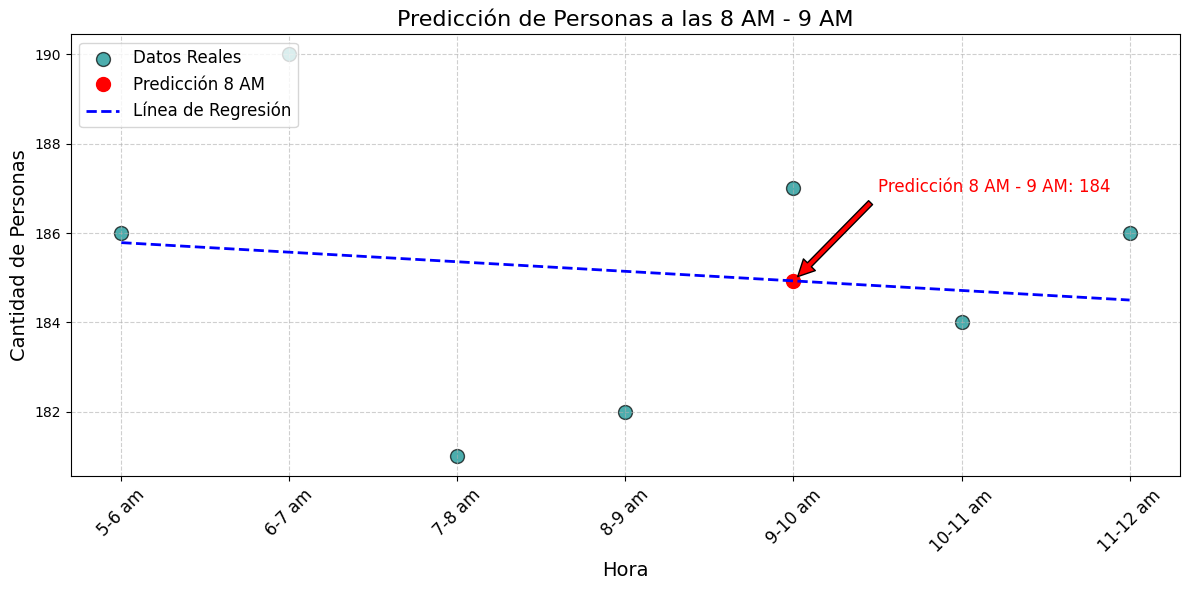

In [271]:
# Predicción de la cantidad de personas para las próximas horas (8 -9 am)
prediccion_1 = modelos[0].predict([[4]])  # Predicción para las 8 am (4 horas)

# Mostrar la predicción en consola
print(f"Alumnos que pasarán a las 8 am: {int(prediccion_1[0])}")

# Crear una figura con tamaño adecuado y estilo mejorado
plt.figure(figsize=(12, 6))

# Graficar los puntos de datos reales
plt.scatter(x[:7], y[:7], color='darkcyan', label='Datos Reales', alpha=0.7, s=100, edgecolor='black')

# Graficar la predicción de las 8 am
plt.plot(4, prediccion_1, 'ro', label='Predicción 8 AM', markersize=10)

# Añadir línea de regresión para los datos
plt.plot(x[:7], modelos[0].predict(np.array(x[:7]).reshape(-1, 1)), color='blue', linestyle='--', label='Línea de Regresión', linewidth=2)

# Añadir anotación para la predicción
plt.annotate(f'Predicción 8 AM - 9 AM: {int(prediccion_1[0])}', 
             xy=(4, prediccion_1), 
             xytext=(4.5, prediccion_1[0] + 2), 
             arrowprops=dict(facecolor='red', shrink=0.05), 
             fontsize=12, color='red')

# Configurar etiquetas y ticks del eje X
plt.xticks(x[:7], list(proyecciones_h.keys())[:7], rotation=45, fontsize=12)

# Añadir título y etiquetas con mejor legibilidad
plt.title('Predicción de Personas a las 8 AM - 9 AM', fontsize=16)
plt.xlabel('Hora', fontsize=14)
plt.ylabel('Cantidad de Personas', fontsize=14)

# Añadir leyenda
plt.legend(loc='upper left', fontsize=12)

# Mostrar el gráfico con una cuadrícula suave
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Mostrar el gráfico
plt.show()
